# Homework 1: Optimizasyon Algoritmalarının Karşılaştırılması

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035


# Veri Seti Seçimi

## Görüntü Veri Seti

Kaggle üzerinde düzenlenen [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) yarışmasında kullanılan veri seti üzerinde training yapılacaktır.

- Veri setinde 12500 adet kedi ve 12500 adet köpek resmi olacak şekilde toplamda 25000 resim bulunmaktadır.
- Bu resimlerin hepsi eğitim süresini uzatacağı için hepsi üzerinde çalışılmamıştır.
- 700 tane sample üzerinde çalışılmıştır. 700 sample training, validation ve test olarak ayrılmıştır.
- Dataset kaggle üzerinden indirilemediğinden Microsoft'un sağladığı [Download Kaggle Cats and Dogs Dataset from Official ...](https://www.microsoft.com/en-us/download/details.aspx?id=54765) sayfası üzerinden indirildi.


# Mevcut GPU Bilgileri


In [180]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [181]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


HOMEWORK_DIR = '/Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework1/'
LOGGER_CONFIG_FILE = HOMEWORK_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.DEBUG)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[DEBUG] [2024-11-16T19:23:08.188Z] This is a debug message that will be wrapped after 140 characters. This is a debug
    message that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.
    This is a debug message that will be wrapped after 140 characters. This is a debug message that will be wrapped after
    140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message that will be
    wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message
    that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.

[INFO] [2024-11-16T19:23:08.189Z] Logging is configured successfully.


# Train, Validation ve Test Veri Seti Oluşturma

- Veri seti çok büyük olduğu için hepsi üzerinde çalışmayacaktır. Random alınan bir alt küme üzerinde çalışılacaktır.
- Kod bir kez train, test ve validation setini seçtiğinde, yeniden çalıştırıldığında veri seti oluşturma adımını atlayacaktır.
- Bu nedenle eğitim yapılırken hep aynı veri seti üzerinde çalışılır.
- İhtiyaç olursa manuel olarak alt küme içerisindeki dosyalar değiştirilebilir veya silinerek yeni kümeler seçilmesi sağlanabilir.


In [ ]:
import os
import shutil
import random
import glob

# 25000 cats and dogs images
SOURCE_DATA_DIR = os.path.join(HOMEWORK_DIR, 'kagglecatsanddogs_5340/PetImages/')
SOURCE_CAT_DATA_DIR = os.path.join(SOURCE_DATA_DIR, 'Cat')
SOURCE_DOG_DATA_DIR = os.path.join(SOURCE_DATA_DIR, 'Dog')

# Sub sample the data for faster training
TARGET_DATA_DIR = os.path.join(HOMEWORK_DIR, 'img_data')
TARGET_TRAIN_DIR = os.path.join(HOMEWORK_DIR, 'img_data/train')
TARGET_TEST_DIR = os.path.join(HOMEWORK_DIR, 'img_data/test')
TARGET_VALIDATION_DIR = os.path.join(HOMEWORK_DIR, 'img_data/validation')

os.chdir(HOMEWORK_DIR)
logger.debug('Current working directory: %s', os.getcwd())


def select_random_samples(from_data_dir, to_data_dir, animal_name, n_of_samples):
    to_data_dir = os.path.join(to_data_dir, animal_name)
    print()
    logger.info("Selecting %d random samples from '%s' to '%s'", n_of_samples,
                os.path.relpath(from_data_dir), os.path.relpath(to_data_dir))

    os.chdir(from_data_dir)

    # sample file names change from 0.jpg to 12499.jpg
    random_samples = random.sample(glob.glob('*.jpg'), n_of_samples)
    for sample_file_name in random_samples:

        # add prefix to the file name as the animal name
        new_file_name = animal_name + '.' + sample_file_name
        shutil.move(sample_file_name, os.path.join(to_data_dir, new_file_name))

    logger.debug('Random samples below moved to %s:', to_data_dir)
    logger.debug(random_samples)

    os.chdir(HOMEWORK_DIR)


# Remove the directory and its contents
# TODO: comment out the line below to keep the data directory
# shutil.rmtree(TARGET_DATA_DIR)

N_OF_TRAIN_SAMPLES = 400
N_OF_VALIDATION_SAMPLES = 200
N_OF_TEST_SAMPLES = 100

# N_OF_TRAIN_SAMPLES = 50
# N_OF_VALIDATION_SAMPLES = 10
# N_OF_TEST_SAMPLES = 20

# Create the directories along with any necessary intermediate directories
if not os.path.exists(TARGET_DATA_DIR):

    if not os.path.exists(TARGET_TRAIN_DIR):
        logger.info("Creating 'train' directories...")
        os.makedirs(TARGET_TRAIN_DIR + '/cat/', exist_ok=True)
        os.makedirs(TARGET_TRAIN_DIR + '/dog/', exist_ok=True)

    if not os.path.exists(TARGET_TEST_DIR):
        logger.info("Creating 'test' directories...")
        os.makedirs(TARGET_TEST_DIR + '/cat/', exist_ok=True)
        os.makedirs(TARGET_TEST_DIR + '/dog/', exist_ok=True)

    if not os.path.exists(TARGET_VALIDATION_DIR):
        logger.info("Creating 'validation' directories...")
        os.makedirs(TARGET_VALIDATION_DIR + '/cat/', exist_ok=True)
        os.makedirs(TARGET_VALIDATION_DIR + '/dog/', exist_ok=True)

    select_random_samples(SOURCE_CAT_DATA_DIR, TARGET_TRAIN_DIR, 'cat', N_OF_TRAIN_SAMPLES)
    select_random_samples(SOURCE_DOG_DATA_DIR, TARGET_TRAIN_DIR, 'dog', N_OF_TRAIN_SAMPLES)

    select_random_samples(SOURCE_CAT_DATA_DIR, TARGET_VALIDATION_DIR, 'cat', N_OF_VALIDATION_SAMPLES)
    select_random_samples(SOURCE_DOG_DATA_DIR, TARGET_VALIDATION_DIR, 'dog', N_OF_VALIDATION_SAMPLES)

    select_random_samples(SOURCE_CAT_DATA_DIR, TARGET_TEST_DIR, 'cat', N_OF_TEST_SAMPLES)
    select_random_samples(SOURCE_DOG_DATA_DIR, TARGET_TEST_DIR, 'dog', N_OF_TEST_SAMPLES)

[DEBUG] [2024-11-16T19:23:08.203Z] Current working directory:
    /Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework1

[INFO] [2024-11-16T19:23:08.244Z] Creating 'train' directories...
[INFO] [2024-11-16T19:23:08.244Z] Creating 'test' directories...
[INFO] [2024-11-16T19:23:08.245Z] Creating 'validation' directories...

[INFO] [2024-11-16T19:23:08.245Z] Selecting 400 random samples from 'kagglecatsanddogs_5340/PetImages/Cat' to
    'img_data/train/cat'

[DEBUG] [2024-11-16T19:23:08.323Z] Random samples below moved to
    /Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework1/img_data/train/cat:

[DEBUG] [2024-11-16T19:23:08.324Z] ['1322.jpg', '3292.jpg', '7373.jpg', '5601.jpg', '678.jpg', '3663.jpg', '544.jpg',
    '7841.jpg', '2832.jpg', '3282.jpg', '863.jpg', '11226.jpg', '331.jpg', '10797.jpg', '2424.jpg', '11247.jpg',
    '11083.jpg', '4141.jpg', '521.jpg', '3941.jpg', '12241.jpg', '8377.jpg', '10700.jpg', '7412.jpg', '8348.jpg',
    '10

Yukarıdaki taşıma işlemlerinden sonra veri setindeki örnek sayıları aşağıdaki tablodaki gibi olacaktır.


In [183]:
# Creates table for training, testing and validation sets for each animal (cat and dog) counts
import pandas as pd
from IPython.display import display


def count_animals_in_path(data_dir):
    count = len(os.listdir(data_dir))
    return count


data_set_df = pd.DataFrame(columns=['Animal', 'Train', 'Test', 'Validation'])
data_set_df.loc[len(data_set_df)] = ['Cat',
                                     count_animals_in_path(TARGET_TRAIN_DIR + '/cat'),
                                     count_animals_in_path(TARGET_TEST_DIR + '/cat'),
                                     count_animals_in_path(TARGET_VALIDATION_DIR + '/cat')]

data_set_df.loc[len(data_set_df)] = ['Dog',
                                     count_animals_in_path(TARGET_TRAIN_DIR + '/dog'),
                                     count_animals_in_path(TARGET_TEST_DIR + '/dog'),
                                     count_animals_in_path(TARGET_VALIDATION_DIR + '/dog')]
display(data_set_df)

,Animal,Train,Test,Validation
0,Cat,400,100,200
1,Dog,400,100,200


# Dataların Batch Olarak Okunması

Veri setini training yapılabilecek bir formata çevirmek için vgg16 ile ön işleme işlemi yapılmıştır.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=TARGET_TRAIN_DIR, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=TARGET_TEST_DIR, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=TARGET_VALIDATION_DIR, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)

# for images, labels in train_batches:
#     print(images.shape, labels.shape)
#     break

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Veri setinin doğru bir şekilde ayrıldığından aşağıdaki kod ile emin olalım.


In [185]:
assert train_batches.n == 2 * N_OF_TRAIN_SAMPLES
assert test_batches.n == 2 * N_OF_TEST_SAMPLES
assert valid_batches.n == 2 * N_OF_VALIDATION_SAMPLES

assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2

Ön işleme işleminden geçirilmiş veriler aşağıdaki gibi standard formata çevrilmiştir.


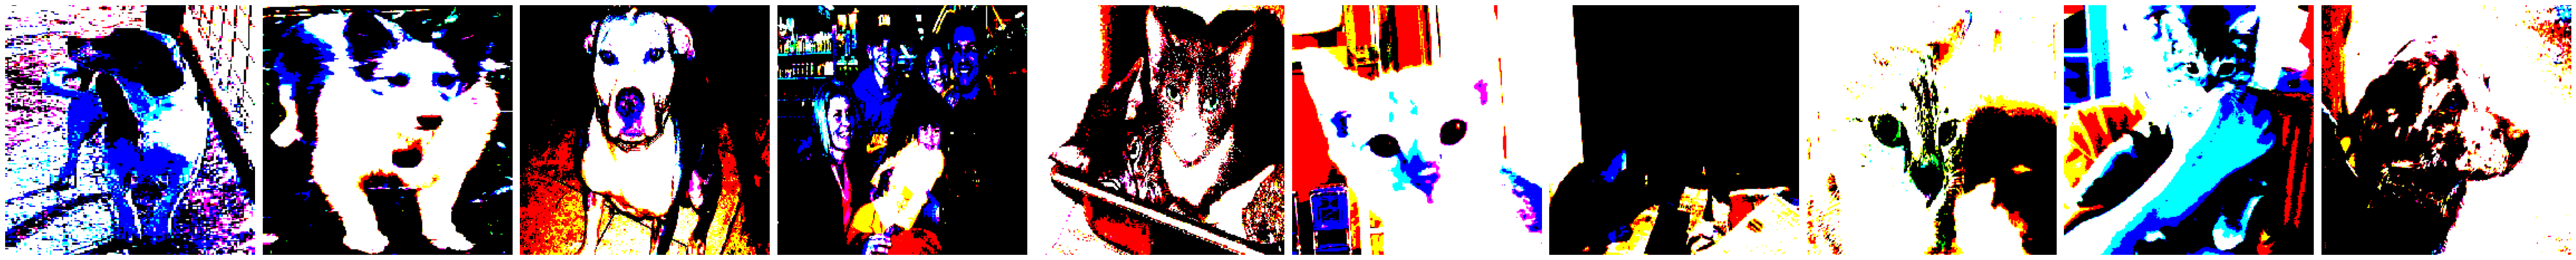

[INFO] [2024-11-16T19:23:09.059Z] [[0. 1.]  [0. 1.]  [0. 1.]  [1. 0.]  [1. 0.]  [1. 0.]  [0. 1.]  [1. 0.]  [1. 0.]  [0.
    1.]]



In [ ]:
import matplotlib.pyplot as plt
imgs, labels = next(train_batches)

# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in each column.


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(50, 50))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
logger.info(labels)

# Hiper Parametrelerin Optimizasyonu

- Hiper parametreleri optimize etmek için aşağıdaki gibi temel metodların yazılması gerekmektedir.
- Aşağıdaki metod hiper parametre değişimi sonrası bir tablo olarak sonuçları yazdırır.


In [187]:
# Final evaluation of the model
def get_model_results(model, optimizer_name, learning_rate, momentum, loss_function):
    results = []

    training_loss, training_accuracy = model.evaluate(train_batches)
    training_accuracy = f"{training_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Train', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': training_loss, 'Accuracy': training_accuracy})

    validation_loss, validation_accuracy = model.evaluate(valid_batches)
    validation_accuracy = f"{validation_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Validation', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': validation_loss, 'Accuracy': validation_accuracy})

    test_loss, test_accuracy = model.evaluate(test_batches)
    test_accuracy = f"{test_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Test', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': test_loss, 'Accuracy': test_accuracy})

    return pd.DataFrame(results)

# Stochastic Gradient Descent (SGD) Optimizer

- Aynı model SGD, SGD with Momentum ve Adam optimizer'larında da kullanılarak optimizer'ların performansları karşılaştırılacaktır.


## Modelin Olusturulması

Model aşağıdaki gibi olacaktır.  
Katmanların ve parametrelerin açıklaması;  
https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/  
https://deeplizard.com/learn/video/ZjM_XQa5s6s


In [188]:
# Create a CNN model
# import all necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

# binary_crossentropy: Model 2 tane sınıfa sahip olduğu zaman kullanılabilir.
# categorical_crossentropy: Model 2 den fazla sınıfa sahip olduğu zaman kesinlikle kullanılması lazım.
#   Fakat 2 sınıflı modelde de kullanılabilir.
#   Output layerda activation function olarak softmax kullanılır.
# sparse_categorical_crossentropy:
model.summary()

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_174 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_87 (Flatten)            │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

## Learning Rete'in Etkisinin İncelenmesi

- Farklı learning rate ler ile modelin başarımı incelendi.
- Denenen learning rate değerleri: 0.0001, 0.001, 0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99


In [189]:
from tensorflow.keras.optimizers import SGD

optimizer_name = 'SGD'
moment = 'N/A'
loss_function = 'binary_crossentropy'


learning_rate_list = [0.0001, 0.001, 0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99]

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 - 8s - 100ms/step - accuracy: 0.5437 - loss: 14.6332 - val_accuracy: 0.5500 - val_loss: 5.7149
Epoch 2/10
80/80 - 7s - 93ms/step - accuracy: 0.7287 - loss: 1.5389 - val_accuracy: 0.6125 - val_loss: 2.0196
Epoch 3/10
80/80 - 7s - 82ms/step - accuracy: 0.8950 - loss: 0.4062 - val_accuracy: 0.6200 - val_loss: 1.7217
Epoch 4/10
80/80 - 7s - 83ms/step - accuracy: 0.9513 - loss: 0.1764 - val_accuracy: 0.6475 - val_loss: 1.4583
Epoch 5/10
80/80 - 6s - 80ms/step - accuracy: 0.9925 - loss: 0.0566 - val_accuracy: 0.6300 - val_loss: 1.5260
Epoch 6/10
80/80 - 7s - 81ms/step - accuracy: 0.9975 - loss: 0.0310 - val_accuracy: 0.6375 - val_loss: 1.4788
Epoch 7/10
80/80 - 6s - 80ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 0.6400 - val_loss: 1.4908
Epoch 8/10
80/80 - 7s - 94ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.6450 - val_loss: 1.4856
Epoch 9/10
80/80 - 7s - 90ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.6350 - val_loss: 1.5084
Epoch 10/10
80/80 -

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD,Train,0.0001,N/A,binary_crossentropy,0.011840,100.00%
1,SGD,Validation,0.0001,N/A,binary_crossentropy,1.513623,62.75%
2,SGD,Test,0.0001,N/A,binary_crossentropy,1.511890,65.00%
3,SGD,Train,0.0010,N/A,binary_crossentropy,0.003815,100.00%
4,SGD,Validation,0.0010,N/A,binary_crossentropy,1.829528,57.25%
5,SGD,Test,0.0010,N/A,binary_crossentropy,2.059899,47.00%
6,SGD,Train,0.0100,N/A,binary_crossentropy,0.687947,50.50%
7,SGD,Validation,0.0100,N/A,binary_crossentropy,1.168529,49.25%
8,SGD,Test,0.0100,N/A,binary_crossentropy,0.751585,49.50%
9,SGD,Train,0.1000,N/A,binary_crossentropy,0.693279,50.00%


# SGD Sonuçlar ve İnceleme

- Genel olarak **modelin** veri seti üzerindeki **performansının kötü** olduğu gözlemlenmiştir.
- Bu nedenle modelin başarımını arttırmak için **learning rate değerlerini değiştirerek** modelin başarımı **incelenmiştir**.
- Learning rate in çoğu değerinde **modelin fitting yapamadığı** gözlemlenmiştir.
- Yukarıda incelenen learning rate değerlerinin sonuçları verilmiştir.
  - En başarılı olan learning rate değeri **0.0001** olmuştur.
  - Bu koşulda bile overfitting olmuş ve modelin hiç görmediği veri seti üzerindeki başarısı **%65** değerinde kalmıştır.


# Plotting History

Modelin çıktılarının çizdirilebilmesi için aşağıdaki gibi bir plot metodu oluşturuldu.


In [190]:
import matplotlib.pyplot as plt


def plot_history(history, optimizer_name):
    train_accuracy_percent = [acc * 100 for acc in history.history['accuracy']]
    validation_accuracy_percent = [acc * 100 for acc in history.history['val_accuracy']]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy_percent)
    plt.plot(validation_accuracy_percent)
    plt.title(optimizer_name + ' Accuracy')
    plt.ylabel('accuracy (%)')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'],)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(optimizer_name + ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.grid(True)

    plt.show()

## Parametrelerin Optimizasyonu Sonrası Modelin Eğitilmesi


- Parametreler optimize edildikten sonra 0.0001 learning rate ve 10 epoch ile modelin başarımı ve sonuçları aşağıdaki gibi çıktı.


Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 7s - 84ms/step - accuracy: 0.5750 - loss: 14.5237 - val_accuracy: 0.6275 - val_loss: 1.7741
Epoch 2/10
80/80 - 7s - 82ms/step - accuracy: 0.8175 - loss: 0.8494 - val_accuracy: 0.6375 - val_loss: 1.9109
Epoch 3/10
80/80 - 6s - 81ms/step - accuracy: 0.9413 - loss: 0.2269 - val_accuracy: 0.6300 - val_loss: 1.3635
Epoch 4/10
80/80 - 7s - 82ms/step - accuracy: 0.9900 - loss: 0.0777 - val_accuracy: 0.6475 - val_loss: 1.3616
Epoch 5/10
80/80 - 6s - 80ms/step - accuracy: 0.9987 - loss: 0.0324 - val_accuracy: 0.6475 - val_loss: 1.3491
Epoch 6/10
80/80 - 6s - 80ms/step - accuracy: 0.9987 - loss: 0.0232 - val_accuracy: 0.6525 - val_loss: 1.3610
Epoch 7/10
80/80 - 7s - 82ms/step - accuracy: 0.9987 - loss: 0.0189 - val_accuracy: 0.6550 - val_loss: 1.3729
Epoch 8/10
80/80 - 7s - 82ms/step - accuracy: 0.9987 - loss: 0.0158 - val_accuracy: 0.6525 - val_loss: 1.3747
Epoch 9/10
80/80 - 7s - 83ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.6575 - val_loss: 1.3862
Epoch 10/10
80/80 - 

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD,Train,0.0001,N/A,binary_crossentropy,0.010827,100.00%
1,SGD,Validation,0.0001,N/A,binary_crossentropy,1.391617,65.25%
2,SGD,Test,0.0001,N/A,binary_crossentropy,1.490236,62.00%


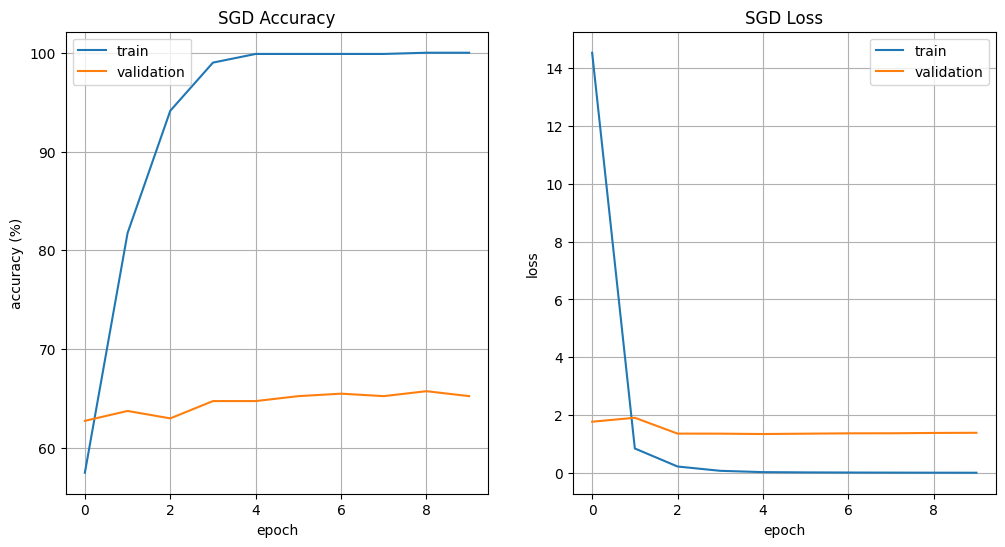

In [191]:
learning_rate = 0.0001

learning_rate_results_df = pd.DataFrame()

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)

display(learning_rate_results_df)
plot_history(history, optimizer_name)

## Test Datası Üzerinden Confision Matrix ve Accuracy Hesaplanması

Test datası üzerindeki tahminlerin confusion matrix ile gösterilmesi için aşağıdaki gibi bir metod yazıldı.


In [216]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- Yukarıda eğittimiz modeli kullanarak test datası üzerinde tahminlerde bulunuyoruz.
- Bunu confusion matrix ile çizdiriyoruz.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion matrix, without normalization
[[47 53]
 [55 45]]


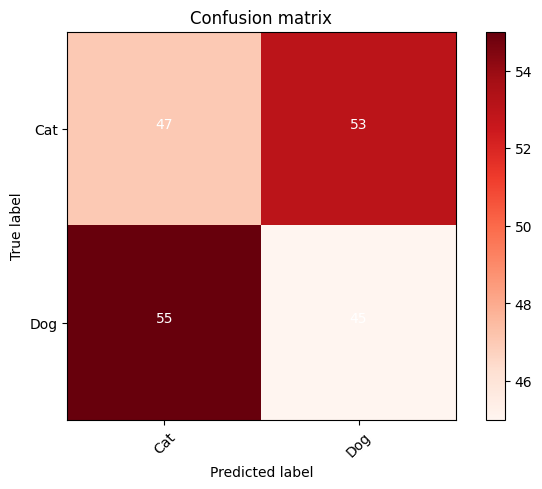

In [217]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_batches)
predictions_max = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=test_batches.labels, y_pred=predictions_max)
plot_confusion_matrix(cm, classes=['Cat', 'Dog'])

Yukarıdaki matrix i yorumlamak gerekirse;

- Positive -> Cat, Negative -> Dog olarak kabul edilirse;

* **True Positive (TP):** 47 adet
* **True Negative (TN):** 45 adet
* **False Positive (FP):** 55 adet
* **False Negative (FN):** 53 adet
  çıkmaktadır.

- Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (47 + 45) / (47 + 45 + 55 + 53) = 92 / 200 = 0.46**


# Stochastic Gradient Descent (SGD) with Momentum

- Burada SGD'nin momentum kabul eden versiyonu kullanılmıştır.
- Modelin yine **çoğu durumda fit edemediği** gözlemlenmiştir.


# Learning Rate ve Momentum'un Etkisinin İncelenmesi


In [194]:
optimizer_name = 'SGD with Momentum'
moment = 0.9

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 7s - 86ms/step - accuracy: 0.5462 - loss: 9.3517 - val_accuracy: 0.5675 - val_loss: 0.7177
Epoch 2/10
80/80 - 7s - 82ms/step - accuracy: 0.8612 - loss: 0.4028 - val_accuracy: 0.5800 - val_loss: 0.7533
Epoch 3/10
80/80 - 7s - 84ms/step - accuracy: 0.9775 - loss: 0.1446 - val_accuracy: 0.5700 - val_loss: 0.9057
Epoch 4/10
80/80 - 7s - 85ms/step - accuracy: 0.9975 - loss: 0.0474 - val_accuracy: 0.5900 - val_loss: 1.0351
Epoch 5/10
80/80 - 7s - 84ms/step - accuracy: 0.9987 - loss: 0.0189 - val_accuracy: 0.6150 - val_loss: 1.1056
Epoch 6/10
80/80 - 6s - 80ms/step - accuracy: 0.9987 - loss: 0.0106 - val_accuracy: 0.5950 - val_loss: 1.1360
Epoch 7/10
80/80 - 6s - 81ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.5925 - val_loss: 1.1945
Epoch 8/10
80/80 - 6s - 81ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.5925 - val_loss: 1.2421
Epoch 9/10
80/80 - 7s - 82ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.6025 - val_loss: 1.2747
Epoch 10/10
80/80 - 7

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.0001,0.9,binary_crossentropy,0.002491,100.00%
1,SGD with Momentum,Validation,0.0001,0.9,binary_crossentropy,1.298520,60.50%
2,SGD with Momentum,Test,0.0001,0.9,binary_crossentropy,1.292773,63.50%
3,SGD with Momentum,Train,0.0010,0.9,binary_crossentropy,0.693149,50.00%
4,SGD with Momentum,Validation,0.0010,0.9,binary_crossentropy,0.693149,50.00%
5,SGD with Momentum,Test,0.0010,0.9,binary_crossentropy,0.693149,50.00%
6,SGD with Momentum,Train,0.0100,0.9,binary_crossentropy,0.693153,50.00%
7,SGD with Momentum,Validation,0.0100,0.9,binary_crossentropy,0.693153,50.00%
8,SGD with Momentum,Test,0.0100,0.9,binary_crossentropy,0.693153,50.00%
9,SGD with Momentum,Train,0.1000,0.9,binary_crossentropy,NaN,50.00%


Yukarıdaki sonuçtan göründüğü üzere en başarılı sonuç **learning rate 0.0001 iken momentumu optimize etmeye** çalışalım.  
Diğer learning rate ler başarısız olmuştur.


In [195]:
learning_rate_results_df = pd.DataFrame()

learning_rate = 0.0001
moment_list = [0.1, 0.4, 0.5, 0.8, 0.9, 0.99]

for moment in moment_list:

    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 8s - 94ms/step - accuracy: 0.5725 - loss: 12.0824 - val_accuracy: 0.5000 - val_loss: 8.9590
Epoch 2/10
80/80 - 7s - 86ms/step - accuracy: 0.7975 - loss: 0.9476 - val_accuracy: 0.5850 - val_loss: 2.7356
Epoch 3/10
80/80 - 7s - 86ms/step - accuracy: 0.9350 - loss: 0.2755 - val_accuracy: 0.6275 - val_loss: 1.4970
Epoch 4/10
80/80 - 8s - 97ms/step - accuracy: 0.9912 - loss: 0.0692 - val_accuracy: 0.6375 - val_loss: 1.4075
Epoch 5/10
80/80 - 7s - 92ms/step - accuracy: 0.9975 - loss: 0.0357 - val_accuracy: 0.6625 - val_loss: 1.3830
Epoch 6/10
80/80 - 7s - 92ms/step - accuracy: 0.9987 - loss: 0.0240 - val_accuracy: 0.6525 - val_loss: 1.3858
Epoch 7/10
80/80 - 7s - 84ms/step - accuracy: 0.9987 - loss: 0.0192 - val_accuracy: 0.6550 - val_loss: 1.3987
Epoch 8/10
80/80 - 8s - 94ms/step - accuracy: 0.9987 - loss: 0.0164 - val_accuracy: 0.6625 - val_loss: 1.3981
Epoch 9/10
80/80 - 8s - 98ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.6575 - val_loss: 1.4004
Epoch 10/10
80/80 - 

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.0001,0.10,binary_crossentropy,0.009860,100.00%
1,SGD with Momentum,Validation,0.0001,0.10,binary_crossentropy,1.408061,65.75%
2,SGD with Momentum,Test,0.0001,0.10,binary_crossentropy,1.479633,68.00%
3,SGD with Momentum,Train,0.0001,0.40,binary_crossentropy,0.010954,100.00%
4,SGD with Momentum,Validation,0.0001,0.40,binary_crossentropy,1.199706,69.00%
5,SGD with Momentum,Test,0.0001,0.40,binary_crossentropy,1.361550,67.00%
6,SGD with Momentum,Train,0.0001,0.50,binary_crossentropy,0.014596,100.00%
7,SGD with Momentum,Validation,0.0001,0.50,binary_crossentropy,1.151375,64.25%
8,SGD with Momentum,Test,0.0001,0.50,binary_crossentropy,1.191098,68.50%
9,SGD with Momentum,Train,0.0001,0.80,binary_crossentropy,0.013961,99.87%


Yukarıdakinden anlaşılacağı üzere **en iyi sonucu learning rate 0.0001 ve momentum 0.4 iken** verdi.

- Algoritmayı geliştirirken daha küçük bir veriseti üzerinde çalışma yapmıştım. Burada en iyi momentum 0.4 çıkmıştı.
- Daha büyük veri seti için aşağıdaki 3 momentum değeri de iyi sonuçlar vermiştir.

```python
# 2	SGD with Momentum	Test	0.0001	0.10	binary_crossentropy	1.479633	68.00%
# 5	SGD with Momentum	Test	0.0001	0.40	binary_crossentropy	1.361550	67.00%
# 8	SGD with Momentum	Test	0.0001	0.50	binary_crossentropy	1.191098	68.50%
```


## Eğitilmiş Model Sonuçları

Momentum 0.4 ve learning rate 0.0001 iken modeli eğitip sonuçları çıktı olarak alalım.


Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 7s - 84ms/step - accuracy: 0.5650 - loss: 9.5177 - val_accuracy: 0.6075 - val_loss: 2.1438
Epoch 2/10
80/80 - 7s - 83ms/step - accuracy: 0.8487 - loss: 0.5626 - val_accuracy: 0.6250 - val_loss: 1.2331
Epoch 3/10
80/80 - 6s - 79ms/step - accuracy: 0.9625 - loss: 0.1511 - val_accuracy: 0.6550 - val_loss: 1.1408
Epoch 4/10
80/80 - 7s - 82ms/step - accuracy: 0.9950 - loss: 0.0513 - val_accuracy: 0.6525 - val_loss: 1.1621
Epoch 5/10
80/80 - 6s - 80ms/step - accuracy: 0.9987 - loss: 0.0304 - val_accuracy: 0.6450 - val_loss: 1.1715
Epoch 6/10
80/80 - 7s - 83ms/step - accuracy: 0.9987 - loss: 0.0236 - val_accuracy: 0.6450 - val_loss: 1.1865
Epoch 7/10
80/80 - 7s - 82ms/step - accuracy: 0.9987 - loss: 0.0195 - val_accuracy: 0.6475 - val_loss: 1.1911
Epoch 8/10
80/80 - 7s - 85ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.6400 - val_loss: 1.1974
Epoch 9/10
80/80 - 7s - 82ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.6525 - val_loss: 1.2067
Epoch 10/10
80/80 - 7

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.0001,0.4,binary_crossentropy,0.011437,100.00%
1,SGD with Momentum,Validation,0.0001,0.4,binary_crossentropy,1.215386,64.50%
2,SGD with Momentum,Test,0.0001,0.4,binary_crossentropy,1.081303,73.00%


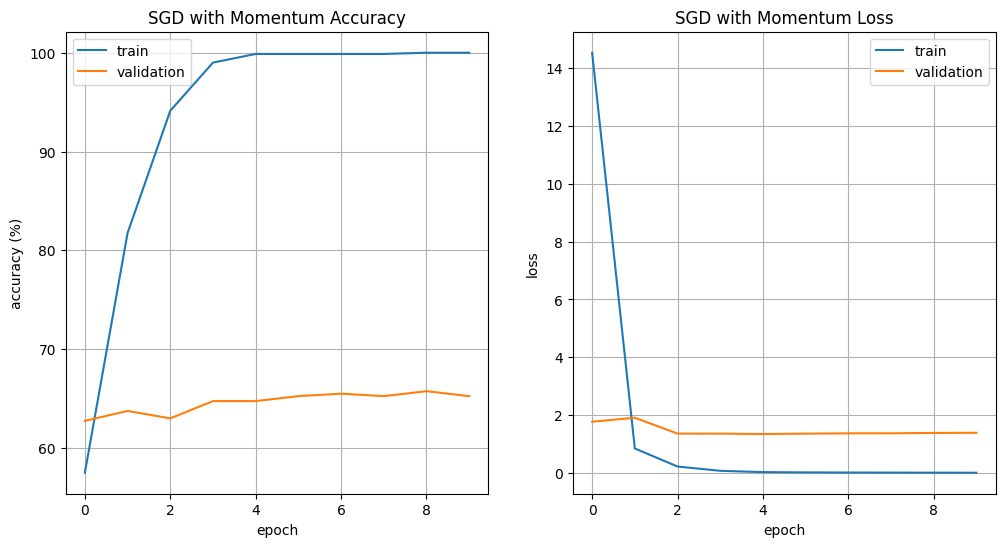

In [196]:
learning_rate = 0.0001
moment = 0.4

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)
display(learning_rate_results_df)

plot_history(history, optimizer_name)

## Test Datası Üzerinde Tahmin Yapılması


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion matrix, without normalization
[[55 45]
 [47 53]]


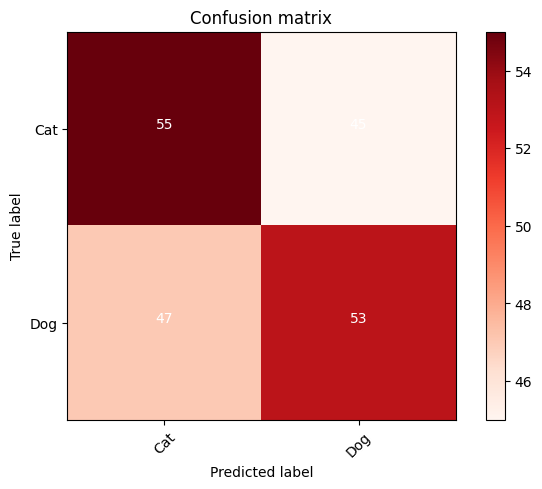

In [227]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_batches)
predictions_max = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=test_batches.labels, y_pred=predictions_max)
plot_confusion_matrix(cm, classes=['Cat', 'Dog'])

Yukarıdaki matrix i yorumlamak gerekirse;

- Positive -> Cat, Negative -> Dog olarak kabul edilirse;

* **True Positive (TP):** 55 adet
* **True Negative (TN):** 53 adet
* **False Positive (FP):** 45 adet
* **False Negative (FN):** 47 adet
  çıkmaktadır.

- Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (55 + 53) / (55 + 53 + 45 + 47) = 108 / 200 = 0.54**


# Adam Optimizer

Adamp optimizer için parametreleri optimize edelim.

# Learning Rate Etkisinin İncelenmesi

- Farklı learning rate ler ile modelin başarımı aşağıdaki şekilde incelenmiştir.


In [198]:
from tensorflow.keras.optimizers import Adam

optimizer_name = 'Adam'
moment = 'N/A'

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 8s - 94ms/step - accuracy: 0.5813 - loss: 9.8658 - val_accuracy: 0.6075 - val_loss: 3.0771
Epoch 2/10
80/80 - 7s - 86ms/step - accuracy: 0.7613 - loss: 1.7881 - val_accuracy: 0.6200 - val_loss: 2.2368
Epoch 3/10
80/80 - 7s - 91ms/step - accuracy: 0.9075 - loss: 0.4878 - val_accuracy: 0.6750 - val_loss: 1.9154
Epoch 4/10
80/80 - 7s - 94ms/step - accuracy: 0.9513 - loss: 0.2168 - val_accuracy: 0.6400 - val_loss: 2.2372
Epoch 5/10
80/80 - 7s - 88ms/step - accuracy: 0.9912 - loss: 0.0828 - val_accuracy: 0.6275 - val_loss: 2.1383
Epoch 6/10
80/80 - 7s - 85ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.6775 - val_loss: 1.7077
Epoch 7/10
80/80 - 7s - 89ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.6600 - val_loss: 1.7029
Epoch 8/10
80/80 - 7s - 86ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.6700 - val_loss: 1.6861
Epoch 9/10
80/80 - 7s - 87ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6750 - val_loss: 1.6888
Epoch 10/10
80/80 - 7

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,Adam,Train,0.0001,N/A,binary_crossentropy,0.001293,100.00%
1,Adam,Validation,0.0001,N/A,binary_crossentropy,1.693343,67.50%
2,Adam,Test,0.0001,N/A,binary_crossentropy,1.690476,66.00%
3,Adam,Train,0.0010,N/A,binary_crossentropy,0.001648,100.00%
4,Adam,Validation,0.0010,N/A,binary_crossentropy,1.938106,52.50%
5,Adam,Test,0.0010,N/A,binary_crossentropy,2.065865,56.50%
6,Adam,Train,0.0100,N/A,binary_crossentropy,0.693165,50.00%
7,Adam,Validation,0.0100,N/A,binary_crossentropy,0.693165,50.00%
8,Adam,Test,0.0100,N/A,binary_crossentropy,0.693165,50.00%
9,Adam,Train,0.1000,N/A,binary_crossentropy,0.693760,50.00%


Yukarıda görüldüğü gibi model sadece learning rate 0.0001 ve 0.001 iken fit edebilmiştir.

- Bu durumda da over fitting olmuştur.

Diğer durumlarda model bir türlü sonuca ulaşamamış ve train datası üzerinde bile %100 doğru sonuç verememiştir.

```python
# 2	Adam	Test	0.0001	N/A	binary_crossentropy	1.690476	66.00%
# 5	Adam	Test	0.0010	N/A	binary_crossentropy	2.065865	56.50%
```


## Eğitilmiş Model Sonuçları

Learning rate 0.0001 iken modeli eğitip sonuçları çıktı olarak alalım.


Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 - 7s - 93ms/step - accuracy: 0.5625 - loss: 12.7148 - val_accuracy: 0.5925 - val_loss: 3.5278
Epoch 2/10
80/80 - 7s - 86ms/step - accuracy: 0.7487 - loss: 1.6658 - val_accuracy: 0.6375 - val_loss: 2.4306
Epoch 3/10
80/80 - 7s - 89ms/step - accuracy: 0.8750 - loss: 0.5588 - val_accuracy: 0.6375 - val_loss: 2.3813
Epoch 4/10
80/80 - 7s - 86ms/step - accuracy: 0.9800 - loss: 0.1388 - val_accuracy: 0.6375 - val_loss: 1.8429
Epoch 5/10
80/80 - 7s - 87ms/step - accuracy: 0.9987 - loss: 0.0348 - val_accuracy: 0.6325 - val_loss: 1.7714
Epoch 6/10
80/80 - 7s - 90ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.6300 - val_loss: 1.8168
Epoch 7/10
80/80 - 7s - 85ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.6350 - val_loss: 1.8288
Epoch 8/10
80/80 - 7s - 85ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.6350 - val_loss: 1.8399
Epoch 9/10
80/80 - 7s - 83ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.6350 - val_loss: 1.8493
Epoch 10/10
80/80 - 

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,Adam,Train,0.0001,N/A,binary_crossentropy,0.001464,100.00%
1,Adam,Validation,0.0001,N/A,binary_crossentropy,1.865544,63.00%
2,Adam,Test,0.0001,N/A,binary_crossentropy,1.876805,70.00%


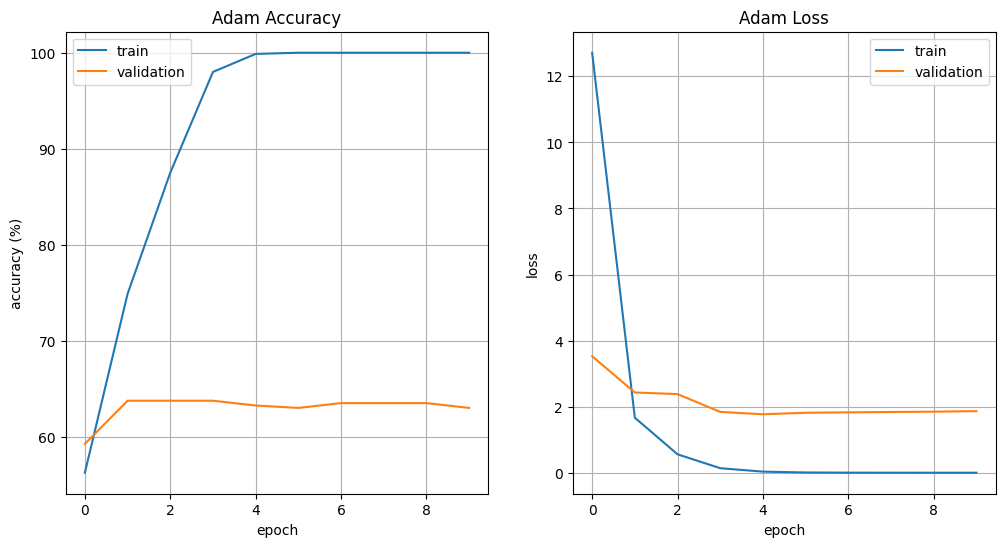

In [199]:
learning_rate = 0.0001

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, batch_size=10, verbose=2)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)
display(learning_rate_results_df)

plot_history(history, optimizer_name)

# Test Datası Üzerinde Tahmin Yapılması


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion matrix, without normalization
[[56 44]
 [46 54]]


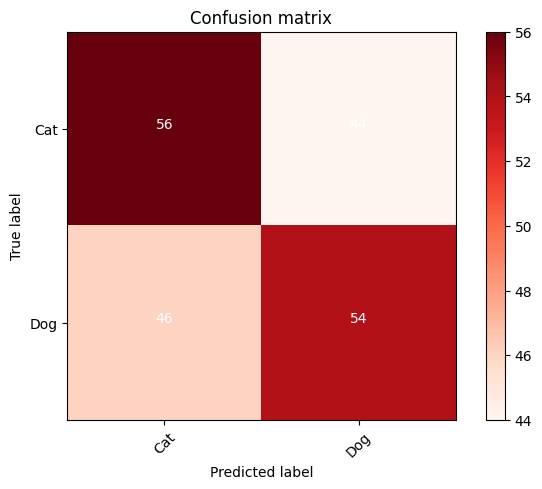

In [228]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_batches)
predictions_max = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=test_batches.labels, y_pred=predictions_max)
plot_confusion_matrix(cm, classes=['Cat', 'Dog'])

Yukarıdaki matrix i yorumlamak gerekirse;

- Positive -> Cat, Negative -> Dog olarak kabul edilirse;

* **True Positive (TP):** 56 adet
* **True Negative (TN):** 54 adet
* **False Positive (FP):** 44 adet
* **False Negative (FN):** 46 adet
  çıkmaktadır.

- Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (56 + 54) / (56 + 54 + 44 + 46) = 110 / 200 = 0.55**


# Sonuçlar

```python
# 2  SGD                 Test  0.0001  N/A  binary_crossentropy  1.490236  62.00%
# 2  SGD with Momentum   Test  0.0001  0.4  binary_crossentropy  1.081303  73.00%
# 2 Adam                 Test  0.0001  N/A  binary_crossentropy  1.876805  70.00%
```

Yurıdaki sonuçlara göre en başarılı sonuç **SGD with Momentum** algoritması ile elde edilmiştir.

- SGD with Momentum > Adam > SGD şeklinde sonuçlar oluşmuştur.


# Referanslar

- [Keras with TensorFlow Course - Python Deep Learning and Neural Networks for Beginners Tutorial](https://youtu.be/qFJeN9V1ZsI?si=m-BV5AwPYay7kBUW)
  - VGG16 ve MobilNet modellerinin kullanımını ve fine tuning işlemlerini öğrenmek için bu kursu izledim.
  - Pretrained modellerin nasıl kullanılacağını ve fine tuning yapılabileceği hakkında bilgi sahibi olmamı sağladı.
  - Transfer learning konusunda bilgi sahibi olmamı sağladı.
